# TP 1: Análisis y Tratamiento de Imágenes Satelitales

### Rodrigo Carlos Fondato
### MCD - 2023

**Solo Colab**: Como primer paso, instalamos openCV y Numpy, luego clonamos el repositorio con los archivos para obtener las imágenes de ejemplo a utilizar:

In [13]:
# Only for Colab
#!pip install numpy==1.23
#!pip install opencv-python==4.7.0.72
#!pip install rasterio

#!git clone https://github.com/rfondato/atis.git

Cargamos librerías comunes a todos los ejercicios:

In [122]:
import cv2
import numpy as np
import math
import os

Cargamos una imagen de ejemplo para todos los ejercicios utilizando openCV:

In [123]:
def get_example_image():
    img_folder_path = './Example Landsat8/'
    image = cv2.imread(f'{img_folder_path}LC08_224-078_2018-01-05_RGB.png')

    # Crop de la imagen dado que tiene 2 bordes grandes negros a los costados
    image = image[0:450, 324:717, :]

    return image

In [124]:
image = get_example_image()

Definimos una función para mostrar imágenes en todos los ejercicios:

In [125]:
# Colab Version

#from google.colab.patches import cv2_imshow
#def show_image(img):
#    cv2_imshow(img)

# Desktop Version

def show_image(img):
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

### **Ejercicios 1 y 2:**

Cargamos una imagen:

In [126]:
def load_image(path):
    return cv2.imread(path)

img_folder_path = './Example Landsat8/'
image = load_image(img_folder_path + 'LC08_224-078_2018-01-05_RGB.png')

La imagen cargada con OpenCV es un array de numpy:

In [127]:
type(image)

numpy.ndarray

El tipo de los elementos del array es uint8, es decir, la imágen tiene una profundidad de 8 bits (valores de 0 a 255) por banda:

In [128]:
image.dtype

dtype('uint8')

Tamaño de la imagen: 451x1042x3 => 451 filas, 1042 columnas, 3 bandas

In [129]:
image.shape

(451, 1042, 3)

La mostramos (ver definición de la función más arriba):

In [130]:
show_image(image)

Guardamos una copia en la misma carpeta:

In [131]:
cv2.imwrite(img_folder_path + "copy.png", image)

True

Obtenemos el valor del pixel de una imagen:

In [132]:
def get_pixel_value(img, x, y):
  return img[x, y]

In [133]:
print("Pixel (0,324): ", get_pixel_value(image, 0, 324))

Pixel (0,324):  [81 81 34]


In [134]:
print("Pixel (200,500): ", get_pixel_value(image, 200, 500))

Pixel (200,500):  [30 27 12]


Copiamos una parte de la imagen en otro archivo:

In [135]:
# Devuelve una porción de "image", desde (x1,y1) a (x2,y2).
# Si path != None entonces usa ese path para guardar la porción de imágen en el path especificado.
def crop_image(image, x1, y1, x2, y2, path=None):
  cropped = image[x1:x2, y1:y2, :].copy()
  if (path is not None) and (path != ''):
    cv2.imwrite(path, cropped)
  return cropped

In [136]:
cropped = crop_image(image, 0, 324, 200, 524, img_folder_path + "cropped.tif")

In [137]:
show_image(cropped)

### **Ejercicios 3 y 4:**

Cargamos la imagen de ejemplo:

In [138]:
image = get_example_image()
show_image(image)

Definimos una función que retorna un reporte con estadísiticas de los pixels de una sección determinada y la usamos en la imágen de ejemplo.

In [141]:
# Devuelve estadísticas de los pixels de la porción de la imágen entre las coordenadas (x1, y1) y (x2, y2)
def get_pixels_mean_report(image, x1, y1, x2, y2):
  cropped = image[x1:x2, y1:y2, :]
  print("Número de pixels:", cropped.size)
  print("Dimensiones:", cropped.shape)
  print("Cantidad de bandas:", cropped.shape[2])
  print("Promedio de nivel de gris por banda:", np.mean(image, axis=(0, 1)))
  print("Promedio general de color:", np.mean(image))
  return cropped

In [142]:
selected_section = get_pixels_mean_report(image, 0, 100, 200, 300)

Número de pixels: 120000
Dimensiones: (200, 200, 3)
Cantidad de bandas: 3
Promedio de nivel de gris por banda: [66.67004806 77.32763359 55.44628781]
Promedio general de color: 66.48132315521629


In [143]:
show_image(selected_section)

### **Ejercicio 5:**

### Carga de imagen de Landsat8 con 7 bandas:

Para los siguientes ejercicios, definimos un mecanismo para cargar múltiples bandas en una sola matriz:

In [144]:
landsat8_bands_folder = './Landsat8 - Tiff/'

# Carga una banda y la devuelve, desde la carpeta y el archivo determinado
def load_landsat8_band(folder_path, file):
    print("Loaded Band:", file)
    band = cv2.imread(folder_path + file)
    return band[:,:, 0]

# Carga una imágen de landsat8 desde una carpeta en folder_path.
# prefix => Prefijo a utilizar para buscar los archivos de bandas
# img_extension => Extensión de los archivos de banda. Por defecto .tif
# Devuelve la imágen y un diccionario con el nombre de cada banda
def load_landsat8_image(folder_path, prefix, img_extension = ".tif"):
    bands = [(f.replace(img_extension, "").replace(prefix, ""), load_landsat8_band(folder_path, f)) for f in os.listdir(folder_path) if (f.startswith(prefix) and f.endswith(img_extension))]
    image = np.array([band for _,band in bands])
    image = image.swapaxes(0, 1).swapaxes(1,2)
    bands_index = {name:index for (index, name) in enumerate([name for (name,_) in bands])}
    return image, bands_index

# Uso la función para cargar una imágen
landsat8_image, bands_index = load_landsat8_image(landsat8_bands_folder, "LC08_224-078_2018-01-05_")

Loaded Band: LC08_224-078_2018-01-05_blue.tif
Loaded Band: LC08_224-078_2018-01-05_ca.tif
Loaded Band: LC08_224-078_2018-01-05_green.tif
Loaded Band: LC08_224-078_2018-01-05_nir.tif
Loaded Band: LC08_224-078_2018-01-05_red.tif
Loaded Band: LC08_224-078_2018-01-05_swir1.tif
Loaded Band: LC08_224-078_2018-01-05_swir2.tif


Tamaño de la imágen cargada, tiene 7 bandas: 

In [145]:
landsat8_image.shape

(451, 1042, 7)

Índice de bandas (a que banda corresponde cada número):

In [146]:
bands_index

{'blue': 0, 'ca': 1, 'green': 2, 'nir': 3, 'red': 4, 'swir1': 5, 'swir2': 6}

In [147]:
# Crop de la imagen dado que tiene 2 bordes grandes negros a los costados
landsat8_image = landsat8_image[0:450, 324:717, :]

Calculamos los índices NVDI, NVWI y SVI

In [150]:
def calculate_indexes(landsat_image, bands_index):
    nir = landsat_image[:, :, bands_index["nir"]].astype("float64")
    r = landsat_image[:, :, bands_index["red"]].astype("float64")
    g = landsat_image[:, :, bands_index["green"]].astype("float64")
    
    ndvi = np.divide(nir - r, nir + r, out=np.zeros_like(nir, dtype='float64'), where=(nir + r) != 0)
    ndwi = np.divide(g - nir, g + nir, out=np.zeros_like(nir, dtype='float64'), where=(g + nir) != 0)
    svi = np.divide(nir, r, out=np.zeros_like(r,dtype='float64'), where=r != 0)
    return ndvi, ndwi, svi

In [151]:
ndvi, ndwi, svi = calculate_indexes(landsat8_image, bands_index)

Convertimos los índices a imágenes, ya que van de -1 a 1, y necesitan ser convertidos a valores entre 0 y 255

In [152]:
def convert_index_to_image(index, bit_depth = 8):
    max_value = 2 ** bit_depth - 1
    return (((index - np.min(index)) / (np.max(index) - np.min(index))) * max_value).astype("uint" + str(bit_depth))

In [153]:
ndvi_image = convert_index_to_image(ndvi)
ndwi_image = convert_index_to_image(ndwi)
svi_image = convert_index_to_image(svi)

Mostramos NDVI:

In [154]:
show_image(ndvi_image)

Mostramos NDWI:

In [155]:
show_image(ndwi_image)

Mostramos SVI:

In [156]:
show_image(svi_image)

### **Ejercicio 6:**

Definimos una función que aplica una corrección gamma a la imágen de entrada.
Como parámetros recibe:

* image = La imagen de entrada
* gamma = Coeficiente gamma
* bit_depth = Profundidad de bits usada en la imágen

In [157]:
def gamma_correction(image, gamma, bit_depth = 8):
    L = 2**bit_depth
    c = (L-1)**(1 - gamma)
    return (c * np.power(image, gamma)).astype('uint'+str(bit_depth))

Muestro imagen de NDVI corregida con Gamma = 1.8

In [158]:
show_image(gamma_correction(ndvi_image, 1.8))

Muestro imagen de NDVI corregida con Gamma = 0.7

In [159]:
show_image(gamma_correction(ndvi_image, 0.7))

Muestro imagen de NDVI corregida con Gamma = 0.5

In [160]:
show_image(gamma_correction(ndvi_image, 0.5))

Muestro imagen de NDVI corregida con Gamma = 0.2

In [161]:
show_image(gamma_correction(ndvi_image, 0.2))

### **Ejercicio 7**:

Obtenemos la imagen de ejemplo:

In [162]:
image = get_example_image()
show_image(image)

Definimos una función "invert_color" que realiza una inversión de colores de una banda, y recibe los siguientes parámetros:
* image = La imágen a transformar
* band = La banda de la imágen que será invertida. Si es "None", devuelve la inversión de todas las bandas.
* bit_depth = La profundidad de bits usada en la imágen 

In [163]:
def invert_color(image, band = None, bit_depth = 8):    
    max_value = 2 ** bit_depth - 1
    if band is None:
        return max_value - image

    return  max_value - image[:, :, band]

Inversión de primer banda (Azul):

In [164]:
show_image(invert_color(image, 0))

Inversión de segunda banda (Verde):

In [165]:
show_image(invert_color(image, 1))

Inversión de tercera banda (Rojo):

In [166]:
show_image(invert_color(image, 2))

Inversión de todas las bandas:

In [167]:
show_image(invert_color(image))

### **Ejercicio 8:**

Cargo la imagen de ejemplo:

In [168]:
image = get_example_image()
show_image(image)

Defino una función "histogram" para calcular el histograma de una imágen. Recibe como parámetros:
* image => Imágen a analizar
* band => Banda a analizar
* bit_depth => Profundidad de bits de la imágen

Devuelve un array de 2^bit_depth posiciones con las ocurrencias de cada nivel de gris en la banda

In [169]:
def histogram(image, band, bit_depth = 8):
    hist = np.zeros(2**bit_depth)
    unique_counts = np.unique(image[:, :, band], return_counts=True)
    unique_counts = zip(unique_counts[0], unique_counts[1])
    for value,count in unique_counts:
        hist[value] = count / image[:, :, band].size

    return hist

Calculo los histogramas para cada banda:

In [170]:
hists = [histogram(image, i) for i in range(3)]

Defino una función que grafica los histogramas. Recibe como parámetros:
* hists = Lista de histogramas a graficar
* titles = Lista de títulos para cada histograma.
* main_title = Título general del gráfico

In [171]:
from matplotlib import pyplot as plt

def plot_histograms(hists, titles, main_title):
    fig, ax = plt.subplots(len(hists))
    fig.suptitle(main_title)

    for i in range(len(hists)):
        ax[i].bar(np.linspace(0, len(hists[i]) - 1, len(hists[i])), hists[i])
        ax[i].set_title(titles[i])

    fig.tight_layout(h_pad=1)
    plt.show()

Grafico los histogramas para las 3 bandas RGB de la imágen de ejemplo:

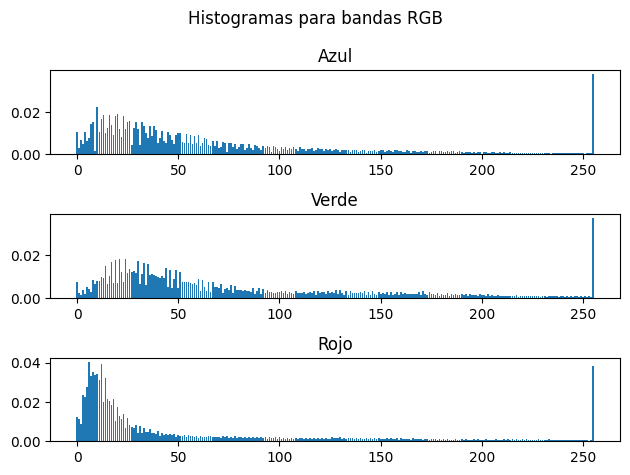

In [172]:
plot_histograms(hists, ["Azul", "Verde", "Rojo"], "Histogramas para bandas RGB")

### **Ejercicio 9:**

Cargo imágen de ejemplo:

In [173]:
image = get_example_image()
show_image(image)

Defino una función "threshold" que realiza una transformación de binarización por umbral en la imágen. Recibe los siguientes parámetros:
* image = La imágen a binarizar
* band = La banda de la imágen a binarizar
* thershold = Valor entero entre 0 y (2 ^ bit_depth - 1). Los valores de los píxels cuyo nivel de gris estén por debajo de éste parámetro serán reemplazados por 0 y aquellos que sean iguales o lo superen, serán reemplazados por (2 ^ bit_depth - 1)
* bit_depth = Profundidad de bits de la imágen

Devuelve la banda binarizada


In [174]:
def threshold(image, band, threshold, bit_depth = 8):
    th_image = np.zeros((image.shape[0], image.shape[1]))
    th_image[image[:, :, band] >= threshold] = (2**bit_depth -1)

    return th_image

Banda: Azul, Umbral: 127

In [175]:
show_image(threshold(image, 0, 127))

Banda: Azul, Umbral: 50

In [176]:
show_image(threshold(image, 0, 50))

Banda: Azul, Umbral: 200

In [177]:
show_image(threshold(image, 0, 200))

Banda: Verde, Umbral: 100

In [178]:
show_image(threshold(image, 1, 100))

Banda: Rojo, Umbral: Media

In [179]:
mean_value = round(np.mean(image[:, :, 2]))
print("Valor medio a utilizar de umbral:", mean_value)

Valor medio a utilizar de umbral: 55


In [180]:
show_image(threshold(image, 2, mean_value))

### **Ejercicio 10:**

Cargo la imágen de ejemplo:

In [181]:
image = get_example_image()
show_image(image)

Defino una función "histogram_equalization" que realiza una ecualización del histograma sobre una banda de la imágen pasada como parámetro y la devuelve.
* image = La imágen a ecualizar
* band = La banda de la imágen a ecualizar
* bit_depth = Profundidad de bits de la imágen

In [182]:
def histogram_equalization(image, band, bit_depth = 8):
    # Obtenemos el histograma utilizando la función "histogram" creada en ejercicios anteriores
    hist = histogram(image, band, bit_depth)

    max_value = 2**bit_depth - 1
   
    # Obtenemos los niveles transformados haciendo la sumatoria hasta nivel k de las frecuencias, por cada nivel del histograma origen
    sk = np.array([np.sum(hist[0:k]) for k in range(len(hist))])
    
    # smin = np.min(sk)
    # sk = np.round((sk - smin) / (1 - smin) + 0.5)
    transformed_levels = sk * max_value

    # Crear una función vectorizada, que por cada elemento transforma el nivel de gris origen 
    # en el nivel de gris del nuevo histograma equalizado.
    transform_function = np.vectorize(lambda rk: transformed_levels[rk])
    return transform_function(image[:, :, band]).astype("uint" + str(bit_depth))

Calculo la equalización para cada banda de la imagen y las muestro:

In [183]:
eqs = [histogram_equalization(image, i) for i in range(image.shape[2])]

In [184]:
for i in range(image.shape[2]):
    show_image(eqs[i])

### **Ejercicio 11:**

Cargo la imágen de ejemplo:

In [185]:
image = get_example_image()
show_image(image)

Defino una función "salt_and_pepper" que agrega éste tipo de ruido a la imagen de entrada. Recibe como parámetros:
* image = La imágen de entrada, a la que se le agregará ruido
* p_salt = Probabilidad de salt (entre 0 y 1). Se genera un número p entre 0 y 1 con distribución uniforme por cada píxel, y si p < p_salt, entonces el nivel de gris del píxel es reemplazado por 255
* p_pepper = Probabilidad de pepper (entre 0 y 1). Se genera un número p entre 0 y 1 con distribución uniforme por cada píxel, y si p > p_pepper, entonces el nivel de gris del píxel es reemplazado por 0
* bit_depth = Profundidad de bits de la imágen

Devuelve la imágen con ruido de sal y pimienta

In [186]:
def salt_and_pepper(image, p_salt = 0.1, p_pepper = 0.1, bit_depth = 8):
    # Genero una matriz de números aleatórios entre 0 y 1, con distribución uniforme, del mismo tamaño que la imagen de entrada
    random = np.random.rand(image.shape[0], image.shape[1])

    # Creo una matríz máscara, donde cada valor de la matriz "random" es reemplazado por -1 si es menor a p_salt, por 1 si es
    # mayor a p_pepper, o por 0 en otro caso.
    mask = np.zeros((image.shape[0], image.shape[1]))
    mask[random < p_salt] = -1
    mask[random > (1 - p_pepper)] = 1
    
    # Calculo el máximo valor de gris
    max_value = 2 ** bit_depth - 1
    
    # Hago una copia de la imágen de entrada y reemplazo todos los pixels donde mask es -1 por el máximo valor (blanco),
    # y todos los pixels donde mask es 1 por el mínimo valor (negro), en TODAS las bandas.
    # El résto de los píxels quedan con valor original.
    noisy_image = image.copy()
    noisy_image[mask == -1, :] = max_value
    noisy_image[mask == 1, :] = 0

    return noisy_image

Ruido de salt and pepper con p_salt y p_pepper = 0.1 (densidad = 0.1)

In [187]:
noisy_image = salt_and_pepper(image, p_salt=0.1, p_pepper=0.1)
show_image(noisy_image)

Ruido de salt and pepper con p_salt y p_pepper = 0.01 (densidad = 0.01)

In [188]:
noisy_image = salt_and_pepper(image, p_salt=0.01, p_pepper=0.01)
show_image(noisy_image)

Ruido de salt and pepper con p_salt = 0.001 y p_pepper = 0.2, es decir mucho ruido pepper y poco salt:

In [189]:
noisy_image = salt_and_pepper(image, p_salt=0.001, p_pepper=0.2)
show_image(noisy_image)

### **Ejercicio 12:**

Defino clases para representar los diferentes operadores convolucionales y el filtro convolucional:

In [192]:
# Interfaz para método de filtrado, que realiza una operación entre 2 matrices y devuelve un número.
class FilterMethod():

    # Método que devuelve el resultado de aplicar el filtro en una porción de imágen, según la clase concreta
    # Por defecto no hace nada, si no es redefinido    
    def apply(self, image_block):
        return image_block
    
    # Devuelve la convolución dentre matrix y kernel (deben ser del mismo tamaño)
    # Método útil para ser usado en clases descendientes
    def _apply_convolution(self, matrix, kernel):
        return np.round(np.sum(np.multiply(matrix, kernel), axis=(0,1)))

# Clase que representa un filtro por la media.
class MeanOperator(FilterMethod):

    # Devuelve la convolución entre image_block y una matriz equivalente de unos, normalizada.
    # El resultado es la media de image_block
    def apply(self, image_block):
        kernel_size = image_block.shape[0]
        kernel = np.ones((kernel_size, kernel_size, 1)) / (kernel_size**2)
        return self._apply_convolution(image_block, kernel)
    
# Clase que representa un filtro por la mediana.
class MedianOperator(FilterMethod):

    # Devuelve la mediana de image_block
    def apply(self, image_block):
        return np.median(image_block, axis=(0,1))

# Clase que representa un filtro por mediana pondereda, dada una máscara de pesos
class WeightedMedianOperator(FilterMethod):
    
    def __init__(self, mask = None) -> None:
        super().__init__()
        self.mask = mask

    # Devuelve la mediana ponderada de image_block, dada una máscara de pesos
    def apply(self, image_block):
        kernel_size = image_block.shape[0]
        kernel = self.mask if self.mask is not None else self._build_default_mask(kernel_size) # Si la máscara no fue provista, construyo una por default.
        
        # Por cada canal uso np.repeat para repetir cada elemento segun el kernel, luego creo un array con todos los canales
        values = np.array([np.repeat(image_block[:,:,i], kernel.flatten()) for i in range(image_block.shape[2])])
        
        # Devuelvo la media de los valores con repetición, sobre cada banda
        return np.median(values, axis=1)
    
    # Método para construir la mascara de pesos por default, si no es provista. El valor central toma el valor 2, y el resto se calcula
    # como la inversa de la distancia a la coordenada central, discretizado utilizando ceil.
    def _build_default_mask(self, kernel_size):
        mask = np.zeros((kernel_size, kernel_size))
        kernel_center = (kernel_size // 2, kernel_size // 2)
        for i in range(kernel_size):
            for j in range(kernel_size):
                mask[i, j] = 1 / np.linalg.norm(np.array(kernel_center) - np.array((i, j))) if ((i,j) != kernel_center) else 2
        
        return np.ceil(mask / np.min(mask)).astype("uint8")

# Clase que representa un filtro de gauss. Recibe como parámetro la desviación estandar a utilizar.
class GaussianOperator(FilterMethod):

    def __init__(self, std = 1):
        self.std = std

    def apply(self, image_block):
        kernel_size = image_block.shape[0]
        kernel = self._build_kernel(kernel_size) # Construyo kernel de gauss, sin normalizar
        kernel = kernel / np.sum(kernel) # Normalizo para que la suma del kernel de 1
        
        # Devuelvo la convolución de la porción de la imágen y el kernel
        return self._apply_convolution(image_block, kernel)

    # Función de densidad de gauss, evaluada en x,y, con desvío std.
    def _evaluate_gaussian(self, x, y):
        c = 1 / math.sqrt(2 * math.pi * (self.std**2))
        return c * math.exp(-(x**2 + y**2) / (self.std**2))

    # Función interna para construir el kernel del filtro, utilizando la función de densidad de gauss
    def _build_kernel(self, kernel_size):
        mask = np.zeros((kernel_size, kernel_size, 1))
        kernel_center = (kernel_size // 2, kernel_size // 2)

        # Calculo gauss evaluado en cada coordenada, centrando en kernel_center
        for i in range(kernel_size):
            for j in range(kernel_size):
                x = i - kernel_center[0]
                y = j - kernel_center[0]
                mask[i,j,0] = self._evaluate_gaussian(x, y)

        # Normalizo al valor mas bajo (siendo 1 el menor valor), y discretizo con round        
        return np.round(mask / np.min(mask))

# Clase que representa un filtro de suavizado
class SmoothingFilter:

    # kernel_size: Tamaño del kernel (matriz cuadrada)
    # filter_method: Objeto de clase FilterMethod que representa el método de suavizado
    def __init__(self, kernel_size = 3, filter_method = MeanOperator()) -> None:      
        self.filter_method = filter_method
        self.kernel_size = kernel_size
        self.kernel_center = kernel_size // 2
        self.top_left_border = self.kernel_center
        self.bot_right_border = self.kernel_size - self.kernel_center - 1
    
    # Función que devuelve el resultado de aplicar el filtro de suavizado sobre la imagen pasada por parámetro.
    # image: Imágen a la cual aplicar el filtro
    # bit_depth: Profunidad de color de la imágen en bits.
    def apply(self, image, bit_depth = 8):
        padded_image = self._add_padding(image) # Primero aplico padding
        filtered_image = np.zeros(image.shape) # Contenedor para imagen a retornar

        # Recorro la imágen con ventanas deslizantes y aplico el filtro por cada ventana
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                filtered_image[i, j, :] = self._filter(padded_image, i, j)
        
        # Casteo imágen a uint con la profundidad pasada por param para discretizar
        return filtered_image.astype(dtype=f"uint{bit_depth}")

    # Método interno que efectúa el filtrado en las coordenadas i,j, siendo (i,j) el vértice superior izq.
    def _filter(self, padded_image, i, j):
        x_start = i
        x_end = i + self.kernel_size
        y_start = j
        y_end = j + self.kernel_size
        return self.filter_method.apply(padded_image[x_start:x_end, y_start:y_end, :])

    # Método para agregar zero padding en los bordes.
    def _add_padding(self, image):
        # Construyo una matriz de 0s del tamaño de la imágen + los bordes
        padded_image = np.zeros((image.shape[0] + self.kernel_size - 1, image.shape[1] + self.kernel_size - 1, image.shape[2]))
        # Ubico la imágen original en el centro de la matriz, considerando los bordes
        padded_image[self.top_left_border:(self.top_left_border + image.shape[0]), self.top_left_border:(self.top_left_border + image.shape[1]), :] = image
        
        return padded_image
    

Filtro de la media, con kernel size = 3:

In [193]:
mean_filter = SmoothingFilter(kernel_size=3, filter_method=MeanOperator())
mean_smoothed_image = mean_filter.apply(image)
show_image(mean_smoothed_image)

Filtro de la media, con kernel size = 6:

In [107]:
mean_filter = SmoothingFilter(kernel_size=6, filter_method=MeanOperator())
mean_smoothed_image = mean_filter.apply(image)
show_image(mean_smoothed_image)

Filtro de mediana, con kernel size = 3:

In [108]:
median_filter = SmoothingFilter(kernel_size=3, filter_method=MedianOperator())
median_smoothed_image = median_filter.apply(image)
show_image(median_smoothed_image)

Filtro de mediana, con kernel size = 6:

In [109]:
median_filter = SmoothingFilter(kernel_size=6, filter_method=MedianOperator())
median_smoothed_image = median_filter.apply(image)
show_image(median_smoothed_image)

Filtro de mediana ponderada, con kernel size = 3:

In [111]:
mask = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
print("Mascara: ")
print(mask)

weigthed_median_filter = SmoothingFilter(kernel_size=3, filter_method=WeightedMedianOperator(mask))
weighted_median_smoothed_image = weigthed_median_filter.apply(image)
show_image(weighted_median_smoothed_image)

Mascara: 
[[1 2 1]
 [2 4 2]
 [1 2 1]]


Filtro de mediana ponderada, con kernel size = 5:

In [113]:
mask = np.array([[1, 2, 3, 2, 1], [2, 3, 4, 3, 2], [3, 4, 6, 4, 3], [2, 3, 4, 3, 2], [1, 2, 3, 2, 1]])
print("Mascara: ")
print(mask)

weigthed_median_filter = SmoothingFilter(kernel_size=5, filter_method=WeightedMedianOperator(mask))
weighted_median_smoothed_image = weigthed_median_filter.apply(image)
show_image(weighted_median_smoothed_image)

Mascara: 
[[1 2 3 2 1]
 [2 3 4 3 2]
 [3 4 6 4 3]
 [2 3 4 3 2]
 [1 2 3 2 1]]


Filtro de gauss kernel size = 3 y std = 1

In [116]:
gaussian_operator = GaussianOperator(std=1)
gaussian_filter = SmoothingFilter(kernel_size=3, filter_method=gaussian_operator)
print("Mascara:")
print(gaussian_operator._build_kernel(3).squeeze())
gaussian_smoothed_image = gaussian_filter.apply(image)
show_image(gaussian_smoothed_image)

Mascara:
[[1. 3. 1.]
 [3. 7. 3.]
 [1. 3. 1.]]


Filtro de gauss kernel size = 3 y std = 0.7

In [117]:
gaussian_operator = GaussianOperator(std=0.7)
gaussian_filter = SmoothingFilter(kernel_size=3, filter_method=gaussian_operator)
print("Mascara:")
print(gaussian_operator._build_kernel(3).squeeze())
gaussian_smoothed_image = gaussian_filter.apply(image)
show_image(gaussian_smoothed_image)

Mascara:
[[ 1.  8.  1.]
 [ 8. 59.  8.]
 [ 1.  8.  1.]]


Filtro de gauss kernel size = 6 y std = 2

In [119]:
gaussian_operator = GaussianOperator(std=2)
gaussian_filter = SmoothingFilter(kernel_size=6, filter_method=gaussian_operator)
print("Mascara:")
print(gaussian_operator._build_kernel(6).squeeze())
gaussian_smoothed_image = gaussian_filter.apply(image)
show_image(gaussian_smoothed_image)

Mascara:
[[ 1.  3.  7.  9.  7.  3.]
 [ 3. 12. 26. 33. 26. 12.]
 [ 7. 26. 55. 70. 55. 26.]
 [ 9. 33. 70. 90. 70. 33.]
 [ 7. 26. 55. 70. 55. 26.]
 [ 3. 12. 26. 33. 26. 12.]]


Filtro de gauss kernel size = 6 y std = 4

In [121]:
gaussian_operator = GaussianOperator(std=4)
gaussian_filter = SmoothingFilter(kernel_size=6, filter_method=gaussian_operator)
print("Mascara:")
print(gaussian_operator._build_kernel(6).squeeze())
gaussian_smoothed_image = gaussian_filter.apply(image)
show_image(gaussian_smoothed_image)

Mascara:
[[1. 1. 2. 2. 2. 1.]
 [1. 2. 2. 2. 2. 2.]
 [2. 2. 3. 3. 3. 2.]
 [2. 2. 3. 3. 3. 2.]
 [2. 2. 3. 3. 3. 2.]
 [1. 2. 2. 2. 2. 2.]]
